🔹 How much revenue is locked in outstanding AR? 
<br> ---- sum total vs total payments
<br>🔹 Which claims remain unresolved longest? 
<br> ---- combine with transactions
<br>🔹 Which payers cause the most delays?
<br> ---- combine with patient details
<br>🔹 Do certain procedures have longer collection times?
<br> ---- combine with transactions
<br>🔹 Do older patients or certain insurance plans have slower payments?
<br> ---- combine with patient details
<br>🔹 What % of AR is overdue? 
<br> ---- sum total vs total payments
<br>🔹 How likely is a bill in "90+ Days" to remain unpaid?
<br>🔹 Which insurance companies pay on time vs. delay payments?
<br> ---- combine with patient details and insurance details
<br>🔹 How often do denied claims result in collection delays?
<br>🔹 Can we predict claims risk, optimize payment reminders?

In [2]:
answers = {
    "revenue_in_AR": 0,
    "longest_claims": 0,
    "delayed_payers": 0,
    "procedure_collection_times": 0,
    "slower_payments": 0,
    "overdue_AR_percentage": 0,
    "liklihood_of_default": 0,
    "insurance_punctuality": 0,
    "denied_claims_to_delays": 0,
    "claims_risk": 0,
}

Datasets Needed
<br>🔹 Aged AR (long form)<br>🔹 Outstanding Claims<br>🔹 Insurance Payments & Adjustments<br>🔹 Processed Payments <br>🔹 Statement Submissions

# Initialization and loading data

In [33]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from collections import defaultdict
import re
import Levenshtein
from itertools import combinations
from scipy.stats import gmean
import profiler as pf
from pandas.plotting import parallel_coordinates

os.chdir('C:/Users/Admin/Documents/GitHub/Data-Guide')

In [3]:
pull_date = pd.to_datetime('2025-02-18')

In [4]:
input_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/transformed_feb_18" 

output_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/analyses_feb_18"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the data
csv_files = {
    "aged_AR" : os.path.join(input_dir, "transformed_aged_AR.csv"),
    "aged_AR_long" : os.path.join(input_dir, "transformed_aged_AR_long.csv"),
    "statement_submission" : os.path.join(input_dir, "transformed_statement_submission.csv"),
    "integrated_payments" : os.path.join(input_dir, "transformed_integrated_payments.csv"),
    #"billing_statement" : os.path.join(input_dir, "billing_statement_report.csv"),
    "outstanding_claims" : os.path.join(input_dir, "transformed_outstanding_claims.csv"),
    # "unresolved_claims" : os.path.join(input_dir, "unresolved_claims_report.csv"),
    #"fee_schedule" : os.path.join(input_dir, "fee_schedule.csv"),
    #"openings" : os.path.join(input_dir,"openings.csv"),
    #"schedule" : os.path.join(input_dir,"schedule.csv"),
#    "patient_details" : os.path.join(input_dir, "transformed_patient_details.csv"),
    "active_patients" : os.path.join(input_dir, "transformed_active_patient_details.csv"),
    "processed_payments": os.path.join(input_dir, "transformed_processed_payments.csv"),
    "payments": os.path.join(input_dir, "transformed_payments.csv"),
    "incurred_charges": os.path.join(input_dir, "transformed_incurred_charges.csv"),
    "transaction_details" : os.path.join(input_dir, "transformed_transaction_details.csv"),
    # "treatment_tracker" : os.path.join(input_dir, "ZR - Treatment Tracker.csv"),
    # "merged_data" : os.path.join(input_dir, "merged_data.csv"),
    'carrier_decision_data' : os.path.join(input_dir, 'Carrier_Decision_Data.csv'),
    'insurance_payment_metrics' : os.path.join(input_dir, 'insurance_payment_metrics.csv'),
    "financial_timeline" : os.path.join(input_dir, "financial_timeline.csv"),
    'time_to_payments' : os.path.join(input_dir, "time_to_payments.csv"),
}
 # Load datasets
dataframes = {dataset: pd.read_csv(file_path) for dataset, file_path in csv_files.items()}

In [5]:
dataframes['aged_AR_long'].head(30)

,Ascend Patient ID,Amount,Bucket,Responsible Party
0,14000002286410,0.0,0-30,Guarantor
1,14000002286410,0.0,0-30,Insurance
2,14000002286410,0.0,0-30,Total
3,14000002286410,86.4,31-60,Guarantor
4,14000002286410,0.0,31-60,Insurance
5,14000002286410,86.4,31-60,Total
6,14000002286410,0.0,61-90,Guarantor
7,14000002286410,0.0,61-90,Insurance
8,14000002286410,0.0,61-90,Total
9,14000002286410,0.0,91+,Guarantor


In [6]:
class AgedARVisualizer:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.buckets = ['0-30', '31-60', '61-90', '91+']
        self.df = self._reshape_data()

    def _reshape_data(self):
        """
        Reshape data so that each row represents a Responsible Party, with Amounts per bucket.
        """
        pivot_df = self.df.pivot_table(index=['Responsible Party', 'Ascend Patient ID'], 
                                       columns='Bucket', values='Amount', aggfunc='sum').fillna(0)
        pivot_df.reset_index(inplace=True)
        return pivot_df

    def plot_subplots(self):
        """
        Create a subplot for each Responsible Party.
        """
        parties = self.df['Responsible Party'].unique()
        fig, axes = plt.subplots(len(parties), 1, figsize=(12, 6 * len(parties)), sharex=True)
        
        if len(parties) == 1:
            axes = [axes]  # Ensure axes is iterable
        
        for ax, party in zip(axes, parties):
            subset = self.df[self.df['Responsible Party'] == party]
            parallel_coordinates(subset, class_column='Responsible Party', cols=self.buckets, ax=ax, colormap='tab10')
            ax.set_title(f'Parallel Coordinates Plot for {party}')
            ax.set_ylabel("Amount")
            ax.legend().remove()
        
        plt.xlabel("Aging Buckets")
        plt.show()

    def plot_colored(self):
        """
        Create a single Parallel Coordinates plot with color-coded Responsible Party (excluding Total & Write-Off).
        """
        filtered_df = self.df[~self.df['Responsible Party'].isin(['Total', 'Write-Off'])]
        plt.figure(figsize=(12, 8))
        parallel_coordinates(filtered_df, class_column='Responsible Party', cols=self.buckets, colormap='tab10')
        plt.title("Parallel Coordinates Plot by Responsible Party")
        plt.ylabel("Amount")
        plt.xlabel("Aging Buckets")
        plt.legend(title='Responsible Party')
        plt.show()


# Data Manipulation

In [24]:
aged_ar_long = dataframes['aged_AR_long'].copy()
aged_ar_long.value_counts('Bucket')

Bucket
0-30     696
31-60    696
61-90    696
91+      696
Name: count, dtype: int64

In [25]:
ar_mapping = {
    '0-30' : (pull_date - pd.DateOffset(days=30), pull_date),
    '31-60' : (pull_date - pd.DateOffset(days=60), pull_date - pd.DateOffset(days=31)),
    '61-90' : (pull_date - pd.DateOffset(days=90), pull_date - pd.DateOffset(days=61)),
    '91+' : (pd.to_datetime('2000-01-01'), pull_date - pd.DateOffset(days=91)),
}

In [26]:
aged_ar_long['timespan'] = aged_ar_long['Bucket'].map(ar_mapping)
ar_long = aged_ar_long.loc[(aged_ar_long['Amount'] != 0) & (aged_ar_long['Responsible Party'] != 'Total')].copy()
ar_long['timespan_start'] = ar_long['timespan'].apply(lambda x: x[0])
ar_long['timespan_end'] = ar_long['timespan'].apply(lambda x: x[1])

In [27]:
ar_long.head(30)

,Ascend Patient ID,Amount,Bucket,Responsible Party,timespan,timespan_start,timespan_end
3,14000002286410,86.40,31-60,Guarantor,"(2024-12-20 00:00:00, 2025-01-18 00:00:00)",2024-12-20,2025-01-18
12,14000002286422,10.40,0-30,Guarantor,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18
25,14000002286423,87.00,0-30,Insurance,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18
42,14000002286424,12.40,61-90,Guarantor,"(2024-11-20 00:00:00, 2024-12-19 00:00:00)",2024-11-20,2024-12-19
51,14000002286431,86.00,31-60,Guarantor,"(2024-12-20 00:00:00, 2025-01-18 00:00:00)",2024-12-20,2025-01-18
63,14000002286442,74.40,31-60,Guarantor,"(2024-12-20 00:00:00, 2025-01-18 00:00:00)",2024-12-20,2025-01-18
66,14000002286442,3.00,61-90,Guarantor,"(2024-11-20 00:00:00, 2024-12-19 00:00:00)",2024-11-20,2024-12-19
85,14000002286485,230.00,0-30,Insurance,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18
103,14000002286492,255.00,61-90,Insurance,"(2024-11-20 00:00:00, 2024-12-19 00:00:00)",2024-11-20,2024-12-19
109,14000002286499,60.00,0-30,Insurance,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18


# AR Visuals

In [27]:
class AgedARVisualizer:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.buckets = ['0-30', '31-60', '61-90', '91+']
        
        print("🔍 Checking initial DataFrame columns:", self.df.columns)
        
        self.df = self._reshape_data()

    def _reshape_data(self):
        """
        Reshape data so that each row represents a Responsible Party, with Amounts per bucket.
        """
        pivot_df = self.df.pivot_table(index=['Responsible Party', 'Ascend Patient ID'], 
                                       columns='Bucket', values='Amount', aggfunc='sum').fillna(0)
        pivot_df.reset_index(inplace=True)

        print("✅ Pivoted DataFrame columns:", pivot_df.columns)  # Debugging

        return pivot_df

    def plot_subplots(self):
        """
        Create a subplot for each Responsible Party.
        """
        parties = self.df['Responsible Party'].unique()
        fig, axes = plt.subplots(len(parties), 1, figsize=(12, 6 * len(parties)), sharex=True)
        
        if len(parties) == 1:
            axes = [axes]  # Ensure axes is iterable
        
        for ax, party in zip(axes, parties):
            subset = self.df[self.df['Responsible Party'] == party]
            
            print(f"🔍 Debugging: Subset for {party} -> Columns:", subset.columns)  # Debugging
            
            if 'Responsible Party' not in subset.columns:
                print(f"❌ 'Responsible Party' is missing from subset for {party}!")
            
            parallel_coordinates(subset, class_column='Responsible Party', cols=self.buckets, ax=ax, colormap='tab10')
            ax.set_title(f'Parallel Coordinates Plot for {party}')
            ax.set_ylabel("Amount")
            ax.legend().remove()
        
        plt.xlabel("Aging Buckets")
        plt.show()

    def plot_colored(self):
        """
        Create a single Parallel Coordinates plot with color-coded Responsible Party (excluding Total & Write-Off).
        """
        filtered_df = self.df[~self.df['Responsible Party'].isin(['Total', 'Write-Off'])]
        
        print("🔍 Filtered DataFrame (plot_colored) columns:", filtered_df.columns)  # Debugging
        
        if 'Responsible Party' not in filtered_df.columns:
            print("❌ 'Responsible Party' is missing from filtered_df!")

        plt.figure(figsize=(12, 8))
        parallel_coordinates(filtered_df, class_column='Responsible Party', cols=self.buckets, colormap='tab10', alpha=0.5)
        plt.title("Parallel Coordinates Plot by Responsible Party")
        plt.ylabel("Amount")
        plt.xlabel("Aging Buckets")
        plt.legend(title='Responsible Party')
        plt.show()


🔍 Checking initial DataFrame columns: Index(['id', 'Ascend Patient ID', 'Amount', 'Bucket', 'Responsible Party',
       'timespan'],
      dtype='object')
✅ Pivoted DataFrame columns: Index(['Responsible Party', 'Ascend Patient ID', '0-30', '31-60', '61-90',
       '91+'],
      dtype='object', name='Bucket')
🔍 Debugging: Subset for Guarantor -> Columns: Index(['Responsible Party', 'Ascend Patient ID', '0-30', '31-60', '61-90',
       '91+'],
      dtype='object', name='Bucket')
🔍 Debugging: Subset for Insurance -> Columns: Index(['Responsible Party', 'Ascend Patient ID', '0-30', '31-60', '61-90',
       '91+'],
      dtype='object', name='Bucket')
🔍 Debugging: Subset for Total -> Columns: Index(['Responsible Party', 'Ascend Patient ID', '0-30', '31-60', '61-90',
       '91+'],
      dtype='object', name='Bucket')


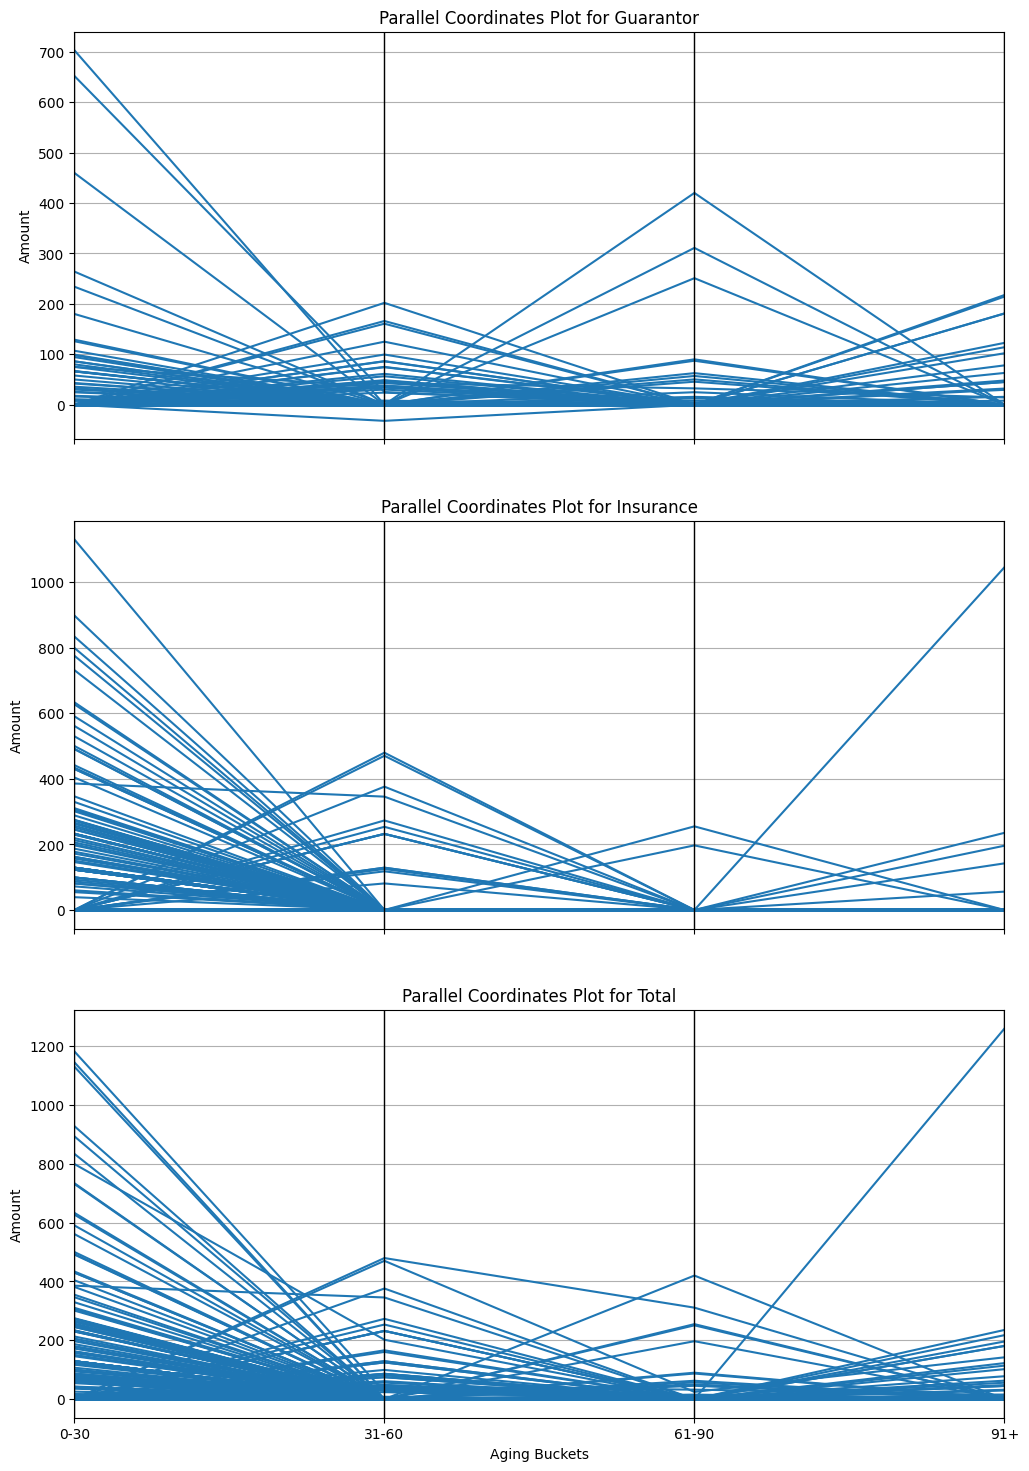

🔍 Filtered DataFrame (plot_colored) columns: Index(['Responsible Party', 'Ascend Patient ID', '0-30', '31-60', '61-90',
       '91+'],
      dtype='object', name='Bucket')


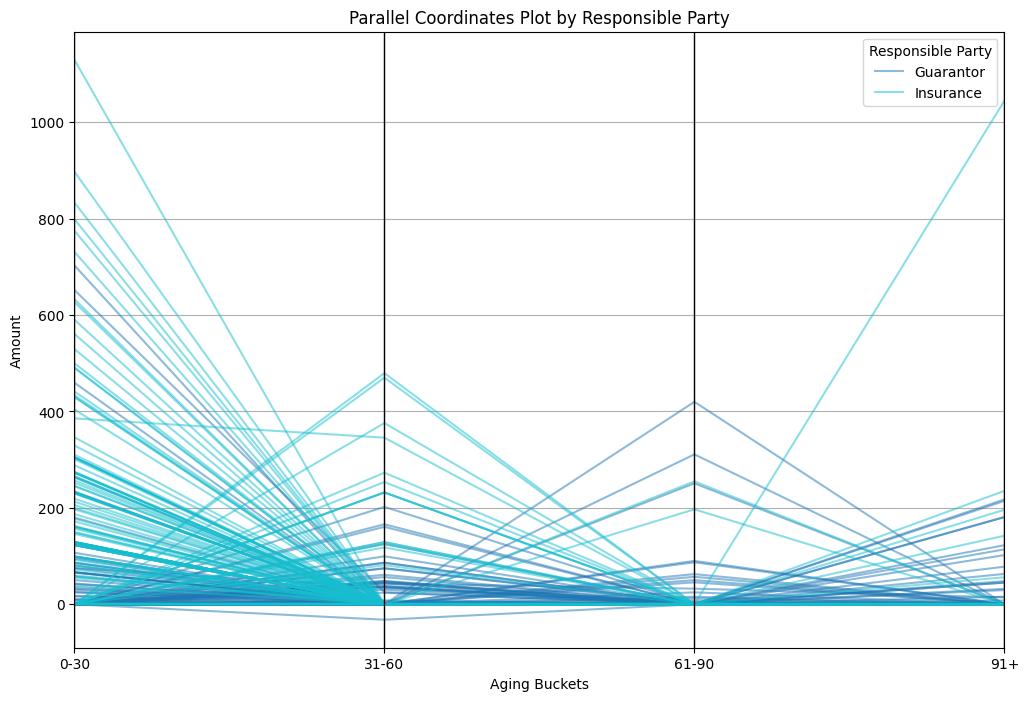

In [28]:
# Example usage
df = pd.DataFrame(aged_ar_long)
    
visualizer = AgedARVisualizer(df)
visualizer.plot_subplots()  # Option 1: Subplots per Responsible Party
visualizer.plot_colored()   # Option 2: Color-coded plot



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\plotting\_matplotlib\misc.py:421: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(x[0], x[-1])


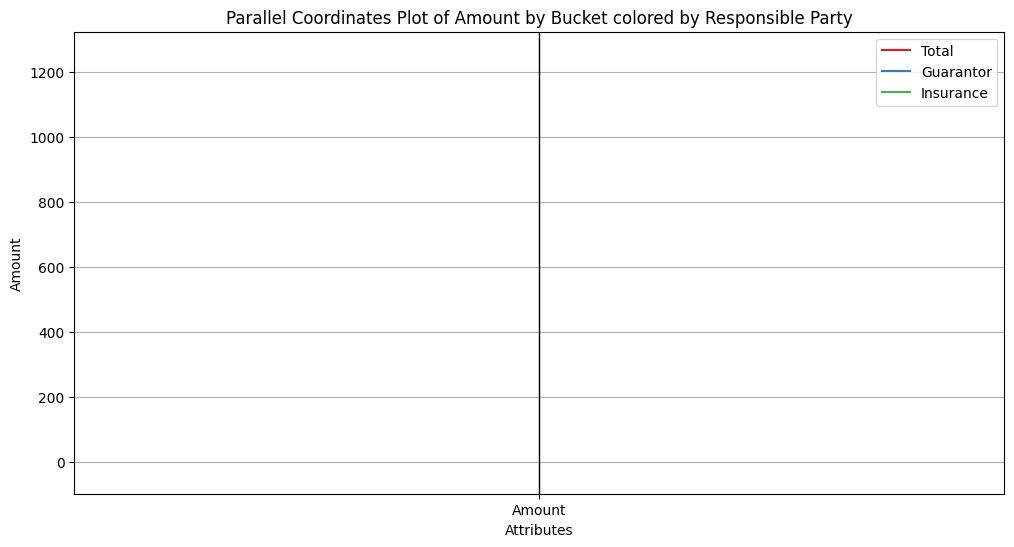

In [11]:
from pandas.plotting import parallel_coordinates

# Parallel Coordinates plot of Amount by Bucket colored by Responsible Party

# Select relevant columns for the plot
plot_data = aged_ar_long[['Amount', 'Bucket', 'Responsible Party']]

# Create the parallel coordinates plot
plt.figure(figsize=(12, 6))
parallel_coordinates(plot_data, class_column='Responsible Party', cols=['Amount'], color=plt.cm.Set1.colors)
plt.title('Parallel Coordinates Plot of Amount by Bucket colored by Responsible Party')
plt.xlabel('Attributes')
plt.ylabel('Amount')
plt.show()



In [28]:
procedures = dataframes['financial_timeline'].query('Category == "Procedures"').copy()
procedures['Date'] = pd.to_datetime(procedures['Date'])
procedures.head(30)

,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value
39,14000002286402,Procedures,2022-04-20,Periodic Evaluation,0,NaN,72.0
40,14000002286402,Procedures,2022-04-20,Prophylaxis - Adult,0,NaN,125.0
41,14000002286402,Procedures,2022-11-01,Bitewing Four Images,0,NaN,91.0
42,14000002286402,Procedures,2022-11-01,Intraoral Periapical Add'l,1,Mouth,35.0
43,14000002286402,Procedures,2022-11-01,Intraoral Periapical Images,1,Mouth,41.0
44,14000002286402,Procedures,2022-11-01,Periodic Evaluation,0,NaN,72.0
45,14000002286402,Procedures,2022-11-01,Prophylaxis - Adult,0,NaN,125.0
46,14000002286402,Procedures,2024-01-02,Periodic Evaluation,1,Mouth,72.0
47,14000002286402,Procedures,2024-01-02,Prophylaxis - Adult,1,Mouth,125.0
48,14000002286402,Procedures,2024-07-05,Bitewing Four Images,1,Mouth,91.0


In [29]:
# Performing the join
merged_df = procedures.merge(ar_long, on="Ascend Patient ID", how="inner")

# Filtering to ensure the procedure date falls within the AR timespan
matched_df = merged_df[
    (merged_df["Date"] >= merged_df["timespan_start"]) & (merged_df["Date"] <= merged_df["timespan_end"])
].drop_duplicates().drop(columns=["timespan", "timespan_start", "timespan_end", 'Category']).sort_values(['Ascend Patient ID', "Date", "Proc. Description"])

In [32]:
matched_df.loc[(matched_df['Bucket'] != "91+") & (matched_df['Responsible Party'] == "Guarantor")].head(30)

,Ascend Patient ID,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value,id,Amount,Bucket,Responsible Party
501,14000002286697,2025-01-09,Prophylaxis - Adult,1,Mouth,138.00,14000002286697,25.0,31-60,Guarantor
1089,14000003773566,2024-12-30,Bitewing Four Images,1,Mouth,91.00,14000003773566,35.0,31-60,Guarantor
1091,14000003773566,2024-12-30,Intraoral Periapical Add'l,1,"Th26, Th23, Th24, Th25",35.00,14000003773566,35.0,31-60,Guarantor
1093,14000003773566,2024-12-30,Intraoral Periapical Images,1,"Th9, Th8, Th7, Th10",41.00,14000003773566,35.0,31-60,Guarantor
1095,14000003773566,2024-12-30,Periodic Evaluation,1,Mouth,72.00,14000003773566,35.0,31-60,Guarantor
1097,14000003773566,2024-12-30,Prophylaxis - Adult,1,Mouth,125.00,14000003773566,35.0,31-60,Guarantor
1850,14000007133433,2025-01-27,Posterior Resin Composite 2s,1,Th3((MO)),355.00,14000007133433,459.7,0-30,Guarantor
2030,14000007527403,2025-02-04,Core Buildup w/ Any Pins,1,Th30,404.00,14000007527403,129.0,0-30,Guarantor
2031,14000007527403,2025-02-04,Full Porcelain/Ceramic Crown,1,Th30,1680.00,14000007527403,129.0,0-30,Guarantor
2064,14000007568082,2025-01-09,Posterior Resin Composite 1s,1,Th30((O)),255.00,14000007568082,45.0,31-60,Guarantor


# Time to Payment

In [53]:
time_to_payments = dataframes['time_to_payments'].copy()
time_to_payments['Date'] = pd.to_datetime(time_to_payments['Date'])

time_to_payments['total_paid'] = time_to_payments['Insurance Payment Amount'] + time_to_payments['Guarantor Payment Amount'] + time_to_payments['Adjustment Payment Amount']

time_to_payments['remaining_balance'] = time_to_payments['Value'] - time_to_payments['total_paid']
time_to_payments = time_to_payments.loc[time_to_payments['remaining_balance'] != 0]
time_to_payments['row_id'] = time_to_payments.index
time_to_payments.head(30)


,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value,Insurance Payment Date,Insurance Payment Amount,Insurance Time to Payment,...,Guarantor Time to Payment,Guarantor Percent Paid,Adjustment Payment Date,Adjustment Payment Amount,Adjustment Time to Payment,Adjustment Percent Paid,Total Payments,total_paid,remaining_balance,row_id
1,14000002286402,Procedures,2022-04-20,Prophylaxis - Adult,0,NaN,125.0,NaN,0.00,NaN,...,36.0,0.66,2022-06-01,39.0,42.0,0.31,82.50,121.50,3.50,1
6,14000002286402,Procedures,2022-11-01,Prophylaxis - Adult,0,NaN,125.0,2022-11-22,86.00,21.0,...,296.0,0.03,2022-11-08,39.0,7.0,0.31,89.50,128.50,-3.50,6
15,14000002286402,Procedures,2025-02-03,Periodic Evaluation,1,Mouth,80.0,NaN,0.00,NaN,...,NaN,NaN,2025-02-03,37.0,0.0,0.46,0.00,37.00,43.00,15
16,14000002286402,Procedures,2025-02-03,Prophylaxis - Adult,1,Mouth,138.0,NaN,0.00,NaN,...,NaN,NaN,2025-02-03,58.0,0.0,0.42,0.00,58.00,80.00,16
17,14000002286402,Procedures,2025-02-03,Topical Applic Fluoride Varnish,1,Mouth,62.0,NaN,0.00,NaN,...,NaN,NaN,2025-02-03,34.0,0.0,0.55,0.00,34.00,28.00,17
20,14000002286403,Procedures,2022-05-26,Core Buildup w/ Any Pins,0,NaN,367.0,2022-06-07,122.50,12.0,...,0.0,0.03,2022-06-07,122.0,12.0,0.33,132.00,254.00,113.00,20
34,14000002286404,Procedures,2021-09-30,Limited Evaluation,1,Mouth,62.0,2022-06-22,62.00,265.0,...,26.0,0.73,NaN,0.0,NaN,NaN,107.00,107.00,-45.00,34
40,14000002286404,Procedures,2022-05-02,Extraction of Erupted Tooth with Bone Removal,1,Th20,391.0,2022-05-17,190.40,15.0,...,NaN,NaN,2022-05-17,153.0,15.0,0.39,190.40,343.40,47.60,40
41,14000002286404,Procedures,2022-05-02,Lower Partial w/ Resin Base,1,"Th19, Th20, Th21",1872.0,2022-05-17,537.50,15.0,...,0.0,0.27,2022-05-17,797.0,15.0,0.43,1043.60,1840.60,31.40,41
43,14000002286404,Procedures,2022-08-25,Limited Evaluation,1,Mouth,107.0,NaN,0.00,NaN,...,49.0,0.16,2022-09-22,45.0,28.0,0.42,17.00,62.00,45.00,43


In [64]:
#time_to_payments['temp'] = time_to_payments['remaining_balance'] * -1
balanced = time_to_payments.merge(time_to_payments, on='Ascend Patient ID', suffixes=('_1', '_2'))
drop_ind = balanced.loc[(balanced['remaining_balance_1'] == balanced['remaining_balance_2'] * -1), ['Ascend Patient ID', 'Date_1', 'Date_2', 'remaining_balance_1', 'remaining_balance_2', 'row_id_1', 'row_id_2']]['row_id_1'].values
drop_ind

array([    1,     6,    34,    43,    48,    50,    84,    87,    93,
          94,    98,    99,   104,   105,   114,   115,   119,   120,
         151,   155,   157,   158,   261,   266,   329,   330,   334,
         335,   378,   379,   384,   385,   522,   523,   524,   525,
         526,   531,   533,   533,   534,   535,   550,   551,   555,
         556,   611,   615,   689,   691,   844,   853,   856,   856,
         857,   857,   862,   863,   864,   865,  1227,  1228,  1229,
        1230,  1231,  1234,  1235,  1236,  1237,  1238,  1239,  1239,
        1269,  1273,  1288,  1293,  1518,  1520,  1525,  1527,  1594,
        1599,  1650,  1652,  1739,  1740,  1746,  1747,  1751,  1751,
        1752,  1753,  1805,  1808,  1863,  1864,  1865,  1866,  1869,
        1870,  1872,  1873,  1877,  1887,  1944,  1945,  1946,  1947,
        1963,  1964,  1965,  1967,  1968,  1969,  1993,  1995,  2032,
        2035,  2040,  2043,  2074,  2075,  2123,  2124,  2125,  2126,
        2164,  2169,

In [65]:
time_to_payments.loc[(~time_to_payments['row_id'].isin(drop_ind))]

,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value,Insurance Payment Date,Insurance Payment Amount,Insurance Time to Payment,...,Guarantor Time to Payment,Guarantor Percent Paid,Adjustment Payment Date,Adjustment Payment Amount,Adjustment Time to Payment,Adjustment Percent Paid,Total Payments,total_paid,remaining_balance,row_id
15,14000002286402,Procedures,2025-02-03,Periodic Evaluation,1,Mouth,80.0,NaN,0.0,NaN,...,NaN,NaN,2025-02-03,37.0,0.0,0.46,0.0,37.0,43.0,15
16,14000002286402,Procedures,2025-02-03,Prophylaxis - Adult,1,Mouth,138.0,NaN,0.0,NaN,...,NaN,NaN,2025-02-03,58.0,0.0,0.42,0.0,58.0,80.0,16
17,14000002286402,Procedures,2025-02-03,Topical Applic Fluoride Varnish,1,Mouth,62.0,NaN,0.0,NaN,...,NaN,NaN,2025-02-03,34.0,0.0,0.55,0.0,34.0,28.0,17
20,14000002286403,Procedures,2022-05-26,Core Buildup w/ Any Pins,0,NaN,367.0,2022-06-07,122.5,12.0,...,0.0,0.03,2022-06-07,122.0,12.0,0.33,132.0,254.0,113.0,20
40,14000002286404,Procedures,2022-05-02,Extraction of Erupted Tooth with Bone Removal,1,Th20,391.0,2022-05-17,190.4,15.0,...,NaN,NaN,2022-05-17,153.0,15.0,0.39,190.4,343.4,47.6,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13985,14000008835950,Procedures,2025-01-31,Full Porcelain/Ceramic Crown,1,Th2,1680.0,2025-02-11,456.5,11.0,...,0.0,0.20,2025-01-31,621.0,0.0,0.37,795.0,1416.0,264.0,13985
13987,14000008835950,Procedures,2025-02-06,Scaling & Root Planing (1-3),3,"Th14, Th15, Th18, Th19, Th30, Th31",879.0,NaN,0.0,NaN,...,0.0,0.10,2025-02-06,438.0,0.0,0.50,88.2,526.2,352.8,13987
13992,14000008839510,Procedures,2025-02-07,Comprehensive Evaluation,1,Mouth,138.0,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,138.0,13992
13999,14000008854703,Procedures,2025-02-03,Posterior Resin Composite 1s,1,Th19((O)),281.0,NaN,0.0,NaN,...,0.0,0.34,NaN,0.0,NaN,NaN,96.2,96.2,184.8,13999


# AR Collection Efficiency & Write-Off Risk<br>
📌 Goal: Identify delinquent accounts, aging trends, and recovery probability.<br>
✅ Steps:<br>

Calculate % of AR in each aging bucket (30, 60, 90, 120+ days).<br>
Rank patients & insurance plans by collections risk.<br>
Identify patterns in write-offs vs. successful collections.<br>
✅ Datasets Used:<br>
Aged AR (long form), Outstanding Claims, Processed Payments<br>
📌 Business Impact:<br>
🚀 Reduces bad debt write-offs.<br>
🚀 Optimizes collection strategy based on payer trends.<br>

# AR Aging Forecasting & Collections Prioritization <br>
📌 Goal: Predict which AR accounts are likely to default.<br>
✅ Approach:<br>

Use time series forecasting (Prophet, ARIMA, LSTMs) to predict AR trends.<br>
Train a classification model to rank overdue accounts by likelihood of non-payment.<br>
✅ Datasets Used:<br>
Aged AR, Processed Payments, Financial Timeline<br>
📌 Business Impact:<br>
🚀 Reduces bad debt by prioritizing high-risk accounts.<br>
🚀 Improves long-term financial planning.<br>

# Answers

In [18]:
aged_ar = dataframes['aged_AR'].copy().drop(columns=['guarantor', 'phoneNumber', 'billingStatement'])

aged_ar = aged_ar.loc[aged_ar['chargeBalance'] > 0, :]

full_ar = aged_ar.merge(dataframes['active_patients'], on='Ascend Patient ID', how='inner').copy()
full_ar

,id,claimsPending,chargeBalance,suspendedCredits,hasInvalidHistories,lastPayment.datedAs,lastPayment.amount,before30.amount,before30.insurancePortion,before30.guarantorPortion,...,City,State,ZIP Code,DCS,DNU,plan_name,plan_name_cruft,university_or_college_plan,Simplest_Equivalent_Plan,plan_name_diff
0,14000002286706,NaN,123.00,0.0,False,1.668710e+12,105.6,123.0,123.0,0.0,...,chicago,IL,60657,True,False,Brookfield HRS TS,NaN,False,brookfield hrs ts,NaN
1,14000002286492,NaN,255.00,0.0,False,1.730135e+12,155.0,0.0,0.0,0.0,...,chicago,IL,60625,NaN,NaN,NaN,NaN,False,NaN,NaN
2,14000002286431,1.0,86.00,0.0,False,1.661809e+12,435.0,0.0,0.0,0.0,...,chicago,IL,60640,False,False,TEMPUS AI,NaN,False,tempus ai,NaN
3,14000008723051,1.0,251.60,0.0,False,1.733870e+12,72.4,251.6,219.2,32.4,...,chicago,IL,60640,False,False,BROWN PARKER DEMARINIS ADVERTISING,NaN,False,brown parker demarinis advertising,NaN
4,14000005232252,NaN,24.00,0.0,False,1.730754e+12,32.0,0.0,0.0,0.0,...,chicago,IL,60640,True,False,AON,NaN,False,aon,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,14000003467559,NaN,125.90,0.0,False,1.733265e+12,125.9,125.9,0.0,125.9,...,chicago,IL,60618,False,False,ACCENTURE LLP,NaN,False,accenture llp,NaN
179,14000008144815,NaN,160.66,0.0,False,1.734455e+12,0.0,0.0,0.0,0.0,...,chicago,IL,60626,True,False,Compass Group USA,NaN,False,compass,group usa
180,14000008681472,1.0,1001.00,0.0,False,1.733247e+12,411.0,799.0,799.0,0.0,...,chicago,IL,60625,False,False,Allstate Insurance Company,NaN,False,allstate insurance company,NaN
181,14000008685913,NaN,273.00,0.0,False,NaN,0.0,273.0,273.0,0.0,...,chicago,IL,60625,False,False,COOK COUNTY,NaN,False,cook county,NaN


**How much revenue is locked in outstanding AR?**
- Number, Donut Chart

In [21]:
ar_revenue = full_ar['chargeBalance'].sum()
ar_revenue

37405.11

**What % of AR is overdue?**
- Number, Donut Chart
- AR greater than 30 days

In [23]:
100 * (ar_revenue - (full_ar['before30.writeOff'].sum() + full_ar['before30.guarantorPortion'].sum() + full_ar['before30.insurancePortion'].sum()))/ ar_revenue

22.835142043426693

**Which insurance companies pay on time vs. delay payments?**
- Distributions by Company
- Parallel Coordinates?

In [30]:
ar_long_revenue = ar_long.merge(dataframes['active_patients'], on='Ascend Patient ID', how='inner').copy()
ar_long_revenue

,Ascend Patient ID,Amount,Bucket,Responsible Party,timespan,timespan_start,timespan_end,Patient,Primary Guarantor,Primary Contact,...,City,State,ZIP Code,DCS,DNU,plan_name,plan_name_cruft,university_or_college_plan,Simplest_Equivalent_Plan,plan_name_diff
0,14000002286410,86.4,31-60,Guarantor,"(2024-12-20 00:00:00, 2025-01-18 00:00:00)",2024-12-20,2025-01-18,"Ager, Robert","Ager, Robert","Ager, Robert",...,chicago,IL,60660,False,True,CHICAGO PUB SCH CAREER CTU,SCH/CAREERCTU,False,chicago pub school,sch career ctu
1,14000002286422,10.4,0-30,Guarantor,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18,"Jilbert, Jennifer","Jilbert, Jennifer","Jilbert, Jennifer",...,chicago,IL,60640,True,True,APPLE,NaN,False,apple,NaN
2,14000002286423,87.0,0-30,Insurance,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18,"Slaughter, Nikki","Slaughter, Nikki","Slaughter, Nikki",...,chicago,IL,60640,False,True,Ernst and Young,NaN,False,ernst and young,NaN
3,14000002286424,12.4,61-90,Guarantor,"(2024-11-20 00:00:00, 2024-12-19 00:00:00)",2024-11-20,2024-12-19,"Suvarna, Mani","Suvarna, Mani","Suvarna, Mani",...,chicago,IL,60613,False,False,Suvarna Chiro,NaN,False,suvarna chiro,NaN
4,14000002286431,86.0,31-60,Guarantor,"(2024-12-20 00:00:00, 2025-01-18 00:00:00)",2024-12-20,2025-01-18,"Williams, Jason","Williams, Jason","Williams, Jason",...,chicago,IL,60640,False,False,TEMPUS AI,NaN,False,tempus ai,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,14000008765870,775.0,0-30,Insurance,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18,"Soto, Luis","Soto, Luis","Soto, Luis",...,chicago,IL,60640,False,False,ABT ELECTRONICS,NaN,False,abt electronics,NaN
201,14000008773350,590.4,0-30,Insurance,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18,"Weidman, Sawyer","Weidman, Sawyer","Weidman, Sawyer",...,chicago,IL,60625,False,False,NEKOOSA COATED PRODUCTS,NaN,False,nekoosa coated products,NaN
202,14000008773351,257.0,0-30,Insurance,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18,"Ronge, Dekyi","Ronge, Dekyi","Ronge, Dekyi",...,chicago,IL,60625,False,False,Delta USA PPO,*USA/PPO,False,delta usa ppo,NaN
203,14000008774784,430.0,0-30,Insurance,"(2025-01-19 00:00:00, 2025-02-18 00:00:00)",2025-01-19,2025-02-18,"King, Madelyn","King, Madelyn","King, Madelyn",...,chicago,IL,60630,False,False,GMR Family Law LLP,NaN,False,gmr family law llp,NaN


In [36]:
carriers = ['Delta Dental', 'Blue Cross Blue Shield', 'MetLife', 'Aetna', 'United Healthcare Dental', 'CIGNA Global Health', 'Guardian', 'Sun Life Financial (PO Box 2940 Clinton IA)', 'Humana']


In [31]:
class AgedARInsuranceVisualizer:
    def __init__(self, dataframe):
        self.df = dataframe.loc[(dataframe['Responsible Party'] == 'Insurance'),:].copy()
        self.buckets = ['0-30', '31-60', '61-90', '91+']
        self.df = self._reshape_data()

    def _reshape_data(self):
        """
        Reshape data so that each row represents a Responsible Party, with Amounts per bucket.
        """
        pivot_df = self.df.pivot_table(index=['Cleaned Carrier', 'Ascend Patient ID'], 
                                       columns='Bucket', values='Amount', aggfunc='sum').fillna(0)
        pivot_df.reset_index(inplace=True)
        return pivot_df


    def plot_colored(self):
        """
        Create a single Parallel Coordinates plot with color-coded Responsible Party (excluding Total & Write-Off).
        """
        filtered_df = self.df
        plt.figure(figsize=(12, 8))
        parallel_coordinates(filtered_df, class_column='Cleaned Carrier', cols=self.buckets, colormap='tab10')
        plt.title("Parallel Coordinates Plot by Carrier")
        plt.ylabel("Amount")
        plt.xlabel("Aging Buckets")
        plt.legend(title='Carrier')
        plt.show()


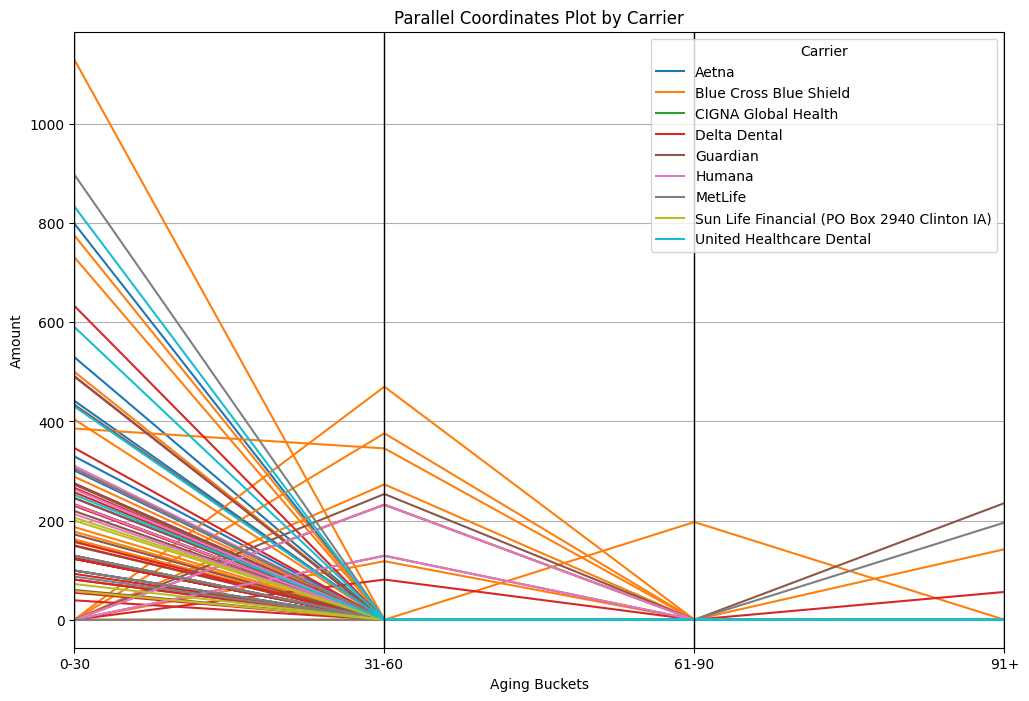

In [37]:
df = pd.DataFrame(ar_long_revenue.loc[ar_long_revenue['Cleaned Carrier'].isin(carriers)])
    
visualizer = AgedARInsuranceVisualizer(df)
visualizer.plot_colored()

**How do insurance payment lag times correlate with patient attrition?**
- Connect to active/inactive patients
- Survival analysis
- Predict returns within 1 year?

**What proportion of claims are still outstanding by payer and procedure?**
- Groupby

**Which payers cause the most delays?**
- Ready

**Which patients have refunds, and what are the insurance carriers & plans?**
- Groupby